## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [3]:
df = pd.read_csv('CICIDS2017_sample.csv') 

In [4]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [5]:
df.Label.value_counts()

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

### Preprocessing (normalization and padding values)

In [6]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling


In [7]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [8]:
df.Label.value_counts()

Label
0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: count, dtype: int64

In [9]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [10]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [11]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [12]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [13]:
df_major['klabel'].value_counts()

klabel
20     482
842    411
312    348
324    337
745    334
      ... 
149      1
879      1
100      1
727      1
71       1
Name: count, Length: 979, dtype: int64

In [14]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [15]:
df_major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.528470,-0.068426,-0.081806,-0.032573,-0.048343,-0.202326,-0.085798,-0.141625,-0.176448,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,402,0
1,-0.524593,0.704878,0.850340,0.027749,0.920410,0.603275,-0.211174,-0.082434,0.240596,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,359,0
2,-0.525233,0.300651,0.339163,0.020443,0.363712,0.603275,-0.211174,0.044064,0.439619,0.484295,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,191,0
3,-0.524560,0.652153,0.745098,0.026625,0.933533,0.603275,-0.211174,-0.074097,0.257378,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,359,0
4,-0.524555,0.757604,0.805237,0.028030,0.960037,0.603275,-0.211174,-0.091861,0.225734,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,359,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,-0.528463,-0.068426,-0.051737,-0.031309,-0.046220,-0.200831,0.457498,-0.064078,-0.255104,-0.517901,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,231,0
56657,-0.524840,-0.068426,-0.051737,-0.029904,-0.043932,-0.178412,0.770939,0.022086,-0.255104,-0.472838,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,934,0
56658,-0.215111,-0.015701,-0.021667,-0.013231,-0.016083,0.423920,-0.211174,0.269089,0.640328,0.711051,...,-0.108682,-0.081786,-0.127669,-0.093554,-0.256386,-0.137651,-0.269448,-0.238252,551,3
56659,-0.215111,0.037025,0.008402,-0.014823,0.058109,0.373103,-0.211174,0.050807,0.399311,1.528310,...,-0.108677,-0.081786,-0.127664,-0.093548,-0.256402,-0.137651,-0.269464,-0.238268,702,3


In [16]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [17]:
result['Label'].value_counts()

Label
3    121
0    116
5     56
2     22
Name: count, dtype: int64

In [18]:
result

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
50964,1.787883,0.037025,0.023436,-0.014683,0.057771,0.368619,-0.211174,0.052962,0.393311,2.050317,...,-0.107200,-0.081786,-0.126501,-0.091950,2.182699,-0.137651,2.105139,2.218466,2,3
19555,-0.527617,-0.068426,-0.051737,-0.030747,-0.046549,-0.191864,0.582875,-0.029612,-0.255104,-0.524390,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,8,0
1229,-0.488956,-0.050851,-0.021667,-0.033088,0.057881,-0.218767,-0.211174,-0.198110,-0.209439,3.620304,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,10,3
2382,-0.366726,-0.015701,-0.081806,-0.032901,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.104492,-0.081786,-0.124367,-0.089020,-0.274051,-0.137651,-0.286646,-0.256045,11,3
4224,-0.499735,-0.033276,-0.081806,-0.033182,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55611,-0.522414,-0.033276,-0.021667,-0.025782,-0.043822,-0.169444,0.582875,0.013470,-0.216571,-0.494468,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,979,0
1203,-0.218026,-0.015701,-0.081806,-0.032901,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.107197,-0.081786,-0.126499,-0.091947,-0.104049,-0.137651,-0.121140,-0.084814,982,3
51743,-0.528251,-0.015701,-0.081806,-0.034306,-0.048343,-0.248659,-0.211174,-0.247894,-0.255104,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,991,3
26950,-0.528468,-0.068426,-0.051737,-0.034119,-0.048233,-0.245670,-0.169382,-0.236405,-0.255104,-0.557556,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,997,0


In [19]:
result = result.drop(['klabel'],axis=1)
result = result._append(df_minor)

In [20]:
result.to_csv('CICIDS2017_sample_km.csv',index=0)

### split train set and test set

In [21]:
# Read the sampled dataset
df=pd.read_csv('CICIDS2017_sample_km.csv')

In [22]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [24]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [25]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [26]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [27]:
X_fs = df[fs].values

In [28]:
X_fs.shape

(4497, 42)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [29]:
!python test.py

No Feature Selection
Classifer: DecisionTree
Best score: 0.8241061452513966

FCBF
Classifer: DecisionTree
Best score: 0.8224581005586593
Elapsed Time: 1.132277250289917

FCBF#
Classifer: DecisionTree
Best score: 0.8246927374301676
Elapsed Time: 1.0197713375091553



Traceback (most recent call last):
  File "C:\Users\26334\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py", line 59, in _wrapfunc
    return bound(*args, **kwds)
           ^^^^^^^^^^^^^^^^^^^^
TypeError: 'float' object cannot be interpreted as an integer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\26334\OneDrive\桌面\车联网\A-MULTI-TIERED-HYBRID-INTRUSION-DETECTION-SYSTEM-FOR-INTERNET-OF-VEHICLES-main\test.py", line 82, in <module>
    fcbfip.fit(dataset.data, dataset.target)
  File "C:\Users\26334\OneDrive\桌面\车联网\A-MULTI-TIERED-HYBRID-INTRUSION-DETECTION-SYSTEM-FOR-INTERNET-OF-VEHICLES-main\FCBF_module.py", line 315, in fit
    SU_x =  np.apply_along_axis(suGroup, 0, x_2d, nfeaturesPieces)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\26334\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\shape_base.py", line 379, in app

In [30]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [31]:
X_fss = fcbf.fit_transform(X_fs,y)

In [32]:
X_fss.shape

(4497, 20)

### Re-split train & test sets after feature selection

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [34]:
X_train.shape

(3597, 20)

In [35]:
pd.Series(y_train).value_counts()

6    1744
1    1572
3      97
0      93
5      45
4      29
2      17
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [36]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [37]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [38]:
pd.Series(y_train).value_counts()

6    1744
1    1572
4    1000
2    1000
3      97
0      93
5      45
Name: count, dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9888888888888889
Precision of XGBoost: 0.9892262494223278
Recall of XGBoost: 0.9888888888888889
F1-score of XGBoost: 0.9884150165307991
              precision    recall  f1-score   support

           0       0.94      0.70      0.80        23
           1       1.00      1.00      1.00       394
           2       0.83      1.00      0.91         5
           3       1.00      0.96      0.98        24
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        11
           6       0.99      1.00      0.99       436

    accuracy                           0.99       900
   macro avg       0.93      0.95      0.94       900
weighted avg       0.99      0.99      0.99       900



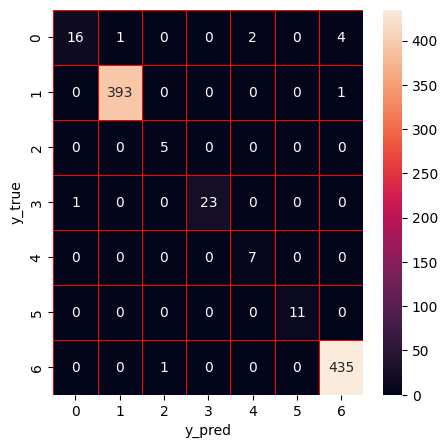

In [39]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)

In [40]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:04<00:00,  4.79trial/s, best loss: -0.9933333333333333]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.6542526455573887, 'max_depth': 39.0, 'n_estimators': 65.0}


Accuracy of XGBoost: 0.9933333333333333
Precision of XGBoost: 0.9936011404814038
Recall of XGBoost: 0.9933333333333333
F1-score of XGBoost: 0.9931573751565619
              precision    recall  f1-score   support

           0       0.95      0.78      0.86        23
           1       1.00      1.00      1.00       394
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        24
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.96      0.97      0.96       900
weighted avg       0.99      0.99      0.99       900



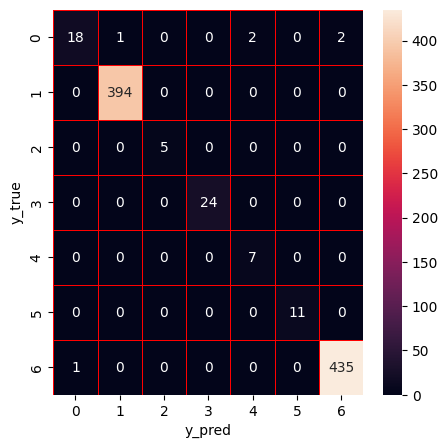

In [41]:
xg = xgb.XGBClassifier(learning_rate= 0.7340229699980686, n_estimators = 70, max_depth = 14)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [42]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.9888888888888889
Precision of RF: 0.9890033159382474
Recall of RF: 0.9888888888888889
F1-score of RF: 0.9888764331331913
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        23
           1       1.00      1.00      1.00       394
           2       1.00      1.00      1.00         5
           3       0.96      0.96      0.96        24
           4       0.62      0.71      0.67         7
           5       1.00      1.00      1.00        11
           6       0.99      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.92      0.92      0.92       900
weighted avg       0.99      0.99      0.99       900



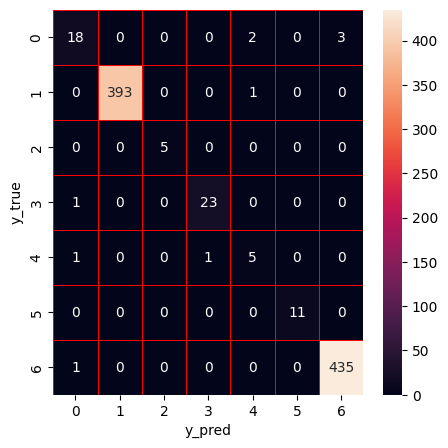

In [43]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)

In [44]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04trial/s, best loss: -0.9911111111111112]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 25.0, 'max_features': 6.0, 'min_samples_leaf': 1.0, 'min_samples_split': 5.0, 'n_estimators': 78.0}


Accuracy of RF: 0.9922222222222222
Precision of RF: 0.9928891475499942
Recall of RF: 0.9922222222222222
F1-score of RF: 0.9922438126566269
              precision    recall  f1-score   support

           0       0.90      0.78      0.84        23
           1       1.00      1.00      1.00       394
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        24
           4       0.70      1.00      0.82         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.94      0.97      0.95       900
weighted avg       0.99      0.99      0.99       900



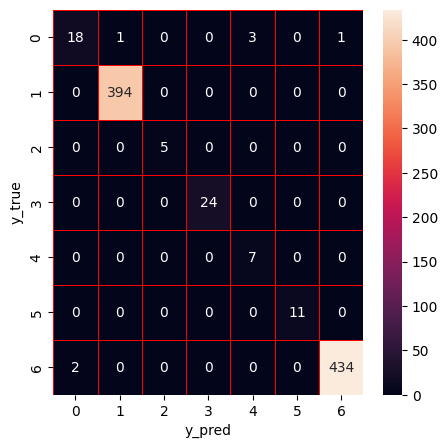

In [45]:
rf_hpo = RandomForestClassifier(n_estimators = 71, min_samples_leaf = 1, max_depth = 46, min_samples_split = 9, max_features = 20, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [46]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9911111111111112
Precision of DT: 0.9917939094547561
Recall of DT: 0.9911111111111112
F1-score of DT: 0.9911901788419836
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        23
           1       1.00      1.00      1.00       394
           2       1.00      1.00      1.00         5
           3       1.00      0.96      0.98        24
           4       0.70      1.00      0.82         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.94      0.96      0.95       900
weighted avg       0.99      0.99      0.99       900



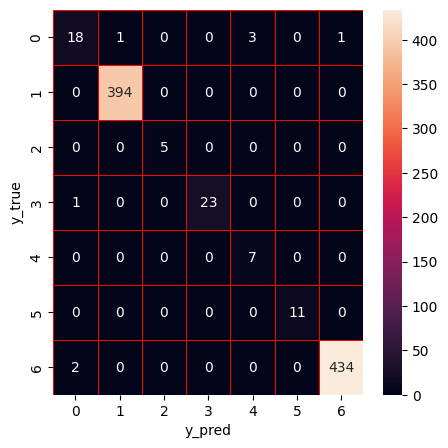

In [47]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)


In [48]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 50/50 [00:01<00:00, 35.83trial/s, best loss: -0.9922222222222222]
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 36.0, 'max_features': 19.0, 'min_samples_leaf': 1.0, 'min_samples_split': 11.0}


Accuracy of DT: 0.9877777777777778
Precision of DT: 0.9883170156387091
Recall of DT: 0.9877777777777778
F1-score of DT: 0.9879315473097197
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        23
           1       0.99      1.00      1.00       394
           2       1.00      1.00      1.00         5
           3       1.00      0.96      0.98        24
           4       0.67      0.86      0.75         7
           5       1.00      1.00      1.00        11
           6       1.00      0.99      0.99       436

    accuracy                           0.99       900
   macro avg       0.93      0.94      0.93       900
weighted avg       0.99      0.99      0.99       900



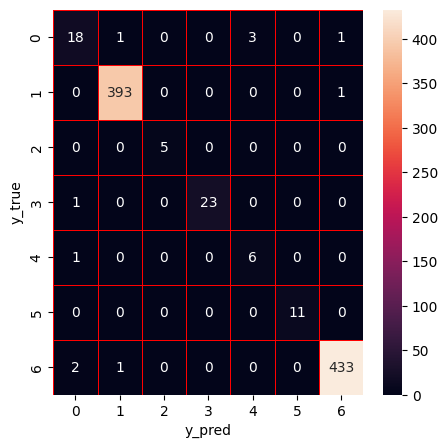

In [49]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 47, min_samples_split = 3, max_features = 19, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [50]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9933333333333333
Precision of ET: 0.9932512641665239
Recall of ET: 0.9933333333333333
F1-score of ET: 0.9930561567674444
              precision    recall  f1-score   support

           0       0.95      0.78      0.86        23
           1       1.00      1.00      1.00       394
           2       1.00      1.00      1.00         5
           3       0.96      0.96      0.96        24
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.97      0.96      0.96       900
weighted avg       0.99      0.99      0.99       900



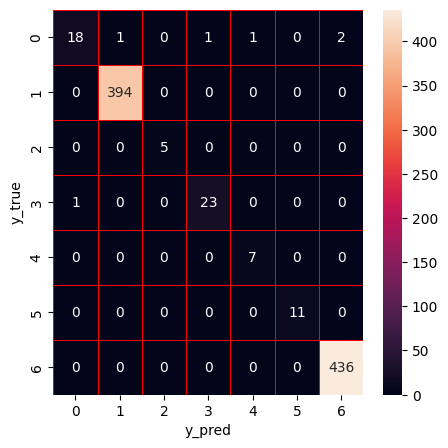

In [51]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)

In [52]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:04<00:00,  4.70trial/s, best loss: -0.9855555555555555]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 34.0, 'max_features': 17.0, 'min_samples_leaf': 3.0, 'min_samples_split': 10.0, 'n_estimators': 105.0}


Accuracy of ET: 0.9933333333333333
Precision of ET: 0.9936183332217088
Recall of ET: 0.9933333333333333
F1-score of ET: 0.9933095908659172
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        23
           1       1.00      1.00      1.00       394
           2       1.00      1.00      1.00         5
           3       1.00      0.96      0.98        24
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.95      0.97      0.96       900
weighted avg       0.99      0.99      0.99       900



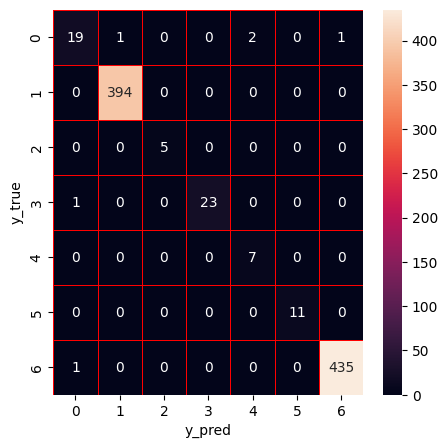

In [53]:
et_hpo = ExtraTreesClassifier(n_estimators = 53, min_samples_leaf = 1, max_depth = 31, min_samples_split = 5, max_features = 20, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [54]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [55]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,1,1,1,1
1,6,6,6,6
2,1,1,1,1
3,6,6,6,6
4,1,1,1,1


In [56]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [57]:
dt_train.shape

(5551, 1)

In [58]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9933333333333333
Precision of Stacking: 0.9936183332217088
Recall of Stacking: 0.9933333333333333
F1-score of Stacking: 0.9933095908659172
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        23
           1       1.00      1.00      1.00       394
           2       1.00      1.00      1.00         5
           3       1.00      0.96      0.98        24
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.95      0.97      0.96       900
weighted avg       0.99      0.99      0.99       900



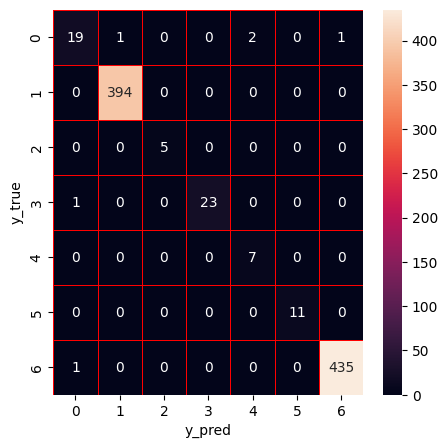

In [59]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)

In [60]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:01<00:00, 12.70trial/s, best loss: -0.9933333333333333]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.3300124703952918, 'max_depth': 89.0, 'n_estimators': 70.0}


Accuracy of XGBoost: 0.9922222222222222
Precision of XGBoost: 0.9928917018284107
Recall of XGBoost: 0.9922222222222222
F1-score of XGBoost: 0.9922339058350339
              precision    recall  f1-score   support

           0       0.90      0.78      0.84        23
           1       1.00      1.00      1.00       394
           2       1.00      1.00      1.00         5
           3       1.00      0.96      0.98        24
           4       0.70      1.00      0.82         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.94      0.96      0.95       900
weighted avg       0.99      0.99      0.99       900



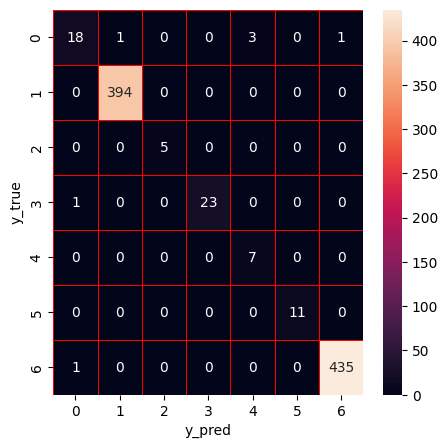

In [61]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [62]:
df=pd.read_csv('CICIDS2017_sample_km.csv')

In [63]:
df.Label.value_counts()

Label
6    2180
1    1966
3     121
0     116
5      56
4      36
2      22
Name: count, dtype: int64

In [64]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('CICIDS2017_sample_km_without_portscan.csv',index=0)

In [65]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('CICIDS2017_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [66]:
df1 = pd.read_csv('CICIDS2017_sample_km_without_portscan.csv')
df2 = pd.read_csv('CICIDS2017_sample_km_portscan.csv')

In [67]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [68]:
df1.Label.value_counts()

Label
1    4325
0     116
Name: count, dtype: int64

In [69]:
df2.Label.value_counts()

Label
1    56
Name: count, dtype: int64

In [70]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [71]:
df2.Label.value_counts()

Label
1    56
0     8
Name: count, dtype: int64

In [72]:
df = df1._append(df2)

In [73]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

1    4381
0     124
Name: count, dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [74]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [75]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [76]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [77]:
X_fs = df[fs].values

In [78]:
X_fs.shape

(4505, 41)

In [79]:
X_fs

array([[-1.23190442, -0.06228152, -0.06228152, ..., -0.0088682 ,
         4.35351158, -0.049534  ],
       [-1.25357316, -0.06681579, -0.06681579, ..., -0.05812213,
        -0.75509301, -0.05605754],
       [-0.60800255, -0.06747676, -0.06747676, ..., -0.05423366,
        -0.56019025, -0.049534  ],
       ...,
       [-1.17280789, -0.06776759, -0.06776759, ..., -0.07108369,
        -0.76385124, -0.05605754],
       [-1.25357316, -0.06729169, -0.06729169, ..., -0.073676  ,
        -0.64048612, -0.06258109],
       [-1.25357316, -0.06668359, -0.06668359, ..., -0.07108369,
        -0.75457195, -0.05605754]])

#### Feature selection by Fast Correlation Based Filter (FCBF)


In [80]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [81]:
X_fss = fcbf.fit_transform(X_fs,y)

In [82]:
X_fss.shape

(4505, 20)

In [83]:
X_fss

array([[-0.31742241, -0.31668159, -0.2209731 , ...,  3.43781886,
        -0.87033993,  3.48536036],
       [ 7.31981317,  7.32233383,  6.71880693, ...,  0.03519261,
        -0.88715795,  0.08679931],
       [-0.31742241, -0.31668159, -0.2209731 , ...,  6.91144893,
        -0.8707675 ,  7.52982719],
       ...,
       [ 0.08453736,  0.08537185,  0.20391139, ..., -0.2532681 ,
        -0.88708669, -0.2561417 ],
       [ 7.72177294,  7.72438727,  3.74461549, ..., -0.04713065,
        -0.88715795,  0.04217   ],
       [ 8.32471259,  8.32746744,  6.64799285, ...,  0.04803504,
        -0.88715795,  0.10206723]])

####  kernel principal component analysis (KPCA)

In [84]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [85]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [86]:
pd.Series(y_train).value_counts()

1    4325
0     116
Name: count, dtype: int64

In [87]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
X_train, y_train = smote.fit_resample(X_train, y_train)

In [88]:
pd.Series(y_train).value_counts()

1    18225
0      116
Name: count, dtype: int64

In [89]:
pd.Series(y_test).value_counts()

1    56
0     8
Name: count, dtype: int64

### Apply the cluster labeling (CL) k-means method

In [90]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [91]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [92]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.78      0.52      0.62        56

    accuracy                           0.45        64
   macro avg       0.39      0.26      0.31        64
weighted avg       0.69      0.45      0.55        64

0.453125
[[ 0  8]
 [27 29]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [93]:
!pip install scikit_optimize

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


DEPRECATION: Loading egg at c:\users\26334\appdata\local\programs\python\python312\lib\site-packages\binwalk-2.3.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [94]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.484375
43 0.96875
43 0.953125
43 0.484375
32 0.453125
20 0.453125
16 0.453125
5 0.875
15 0.453125
25 0.015625
49 0.96875
50 0.46875
2 0.875
40 0.53125
18 0.453125
30 0.46875
18 0.453125
40 0.484375
17 0.453125
11 0.875
4.802840709686279
Best score=0.9688
Best parameters: n_clusters=43


In [95]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

31 0.53125                                                                                                             
33 0.46875                                                                                                             
38 0.890625                                                                                                            
39 0.46875                                                                                                             
2 0.875                                                                                                                
28 0.453125                                                                                                            
5 0.875                                                                                                                
5 0.875                                                                                                                
6 0.875                                 

In [96]:
CL_kmeans(X_train, X_test, y_train, y_test, 16)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.78      0.52      0.62        56

    accuracy                           0.45        64
   macro avg       0.39      0.26      0.31        64
weighted avg       0.69      0.45      0.55        64

0.453125
[[ 0  8]
 [27 29]]
